# Computational Analysis of Huckel Aromaticity in COMPAS's Molecules

Aromaticity is a concept deeply rooted in organic chemistry. The term aromaticity was first coined by August Kekule in 1855 to describe the stability and special properties exhibited by certain cyclic structures. The code provided here utilizes the RDKit library in Python to assess the Huckel aromaticity of the hPAHs molecules in the COMPAS database based on their pi electron count (`4n+2` rule). 

## Import necessary libraries
RDKit is used for working with chemical structures, and additional libraries such as pandas, numpy, seaborn, and matplotlib are used for data manipulation and visualization.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from pathlib import Path

import seaborn as sns
from matplotlib import pyplot as plt

from func import calc_atomisation_energy

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

import mols2grid

# Reload imported libraries automatically
%load_ext autoreload
%autoreload 2

# Define Pi Electron Counting Functions

These functions define the logic for counting pi electrons in a molecule (`count_pi_electrons`) and checking Huckel aromaticity (`huckel_aromaticity`) based on the count.

In [2]:
def count_pi_electrons(mol: Chem.Mol) -> int:
    """
    Returns the number of pi electrons in a molecule

    Input:
    -------
    mol: Chem.Mol
        The RDKit molecule to calculate the number of pi electrons

    Output:
    -------
    n_pi_electrons: int
        Number of pi electrons
    """
    # atoms with lonely pairs
    long_pairs_sma = ['[#7H1]','[#8]','[#16]']   
    # count the number of double bonds
    n_double_bonds = sum([bond.GetBondType() == Chem.rdchem.BondType.DOUBLE for bond in mol.GetBonds()])
    # number of pi electrons
    n_pi_electrons = n_double_bonds * 2
    # add the number of electrons from lone pairs
    for sma in long_pairs_sma:
        n_pi_electrons += len(mol.GetSubstructMatches(Chem.MolFromSmarts(sma)))*2
    return n_pi_electrons

def huckel_aromaticity(n_pi_electrons: int) -> bool:
    """
    Returns True if the number of pi electrons is Huckel aromatic (4n+2)

    Input:
    -------
    n_pi_electrons: int
        Number of pi electrons

    Output:
    -------
    bool
        True if the number of pi electrons is Huckel aromatic (4n+2)
    """
    return (n_pi_electrons - 2) % 4 == 0

def get_huckel_aromaticity_from_mol(mol: Chem.Mol) -> bool:
    """
    Returns True if the molecule is Huckel aromatic

    Input:
    -------
    mol: Chem.Mol
        The RDKit molecule to get Huckel aromaticity

    Output:
    -------
    bool
        True if the molecule is Huckel aromatic
    """
    # kekulize the molecule to avoid dealing with aromatic bonds
    Chem.Kekulize(mol)
    # count the number of pi electrons
    n_pi_electrons = count_pi_electrons(mol)
    return huckel_aromaticity(n_pi_electrons)

def get_huckel_aromaticity_from_smiles(smi:str) -> bool:
    """
    Returns True if the molecule is Huckel aromatic

    Input:
    -------
    smi: str
        The smiles of the molecule to get Huckel aromaticity

    Output:
    -------
    bool
        True if the molecule is Huckel aromatic
    """
    mol = Chem.MolFromSmiles(smi)
    return get_huckel_aromaticity_from_mol(mol)

def get_pi_electron_from_smiles(smi:str) -> int:
    """
    Returns the number of pi electrons in a molecule

    Input:
    -------
    smi: str
        The smiles of the molecule to calculate the number of pi electrons

    Output:
    -------
    n_pi_electrons: int
        Number of pi electrons
    """

    mol = Chem.MolFromSmiles(smi)
    Chem.Kekulize(mol)
    return count_pi_electrons(mol)

def get_pi_electron_from_mol(mol: Chem.Mol) -> int:
    """
    Returns the number of pi electrons in a molecule

    Input:
    -------
    mol: Chem.Mol
        The RDKit molecule to calculate the number of pi electrons

    Output:
    -------
    n_pi_electrons: int
        Number of pi electrons
    """
    Chem.Kekulize(mol)
    return count_pi_electrons(mol)

# Load the COMPAS-2 database

In [3]:
df = pd.read_csv(".temp/data/compas-2x.csv", index_col=0).query('charge == 0').copy()
lala = pd.read_csv(".temp/data/compas-2x-lala.csv", index_col=0)
df = df.merge(lala[['name','lala', 'stereo', 'types']])

In [4]:
moles, electrons, aromaticity = [], [], []
for i, row in df.sample(1000).iterrows():
    mol = Chem.MolFromSmiles(row['smiles'])
    Chem.Kekulize(mol)
    moles.append(mol)
    electrons.append(count_pi_electrons(mol))
    aromaticity.append(huckel_aromaticity(count_pi_electrons(mol)))

data = pd.DataFrame({'mol':moles,'pi_electrons': electrons, 'huckel_aromaticity': aromaticity})

mols2grid.display(data, mol_col='mol', 
                  subset=['img'],
                  size=(200,200),
                  n_cols=6,
                  tooltip=['pi_electrons', 'huckel_aromaticity'])

MolGridWidget()

# Calculate the pi electron count and Huckel aromaticity for each molecule

In [5]:
df['huckel'] = df['smiles'].apply(get_huckel_aromaticity_from_smiles)
df['pie'] = df['smiles'].apply(get_pi_electron_from_smiles)
df[['name','huckel','pie']].to_csv(".temp/data/compas-2x.csv")

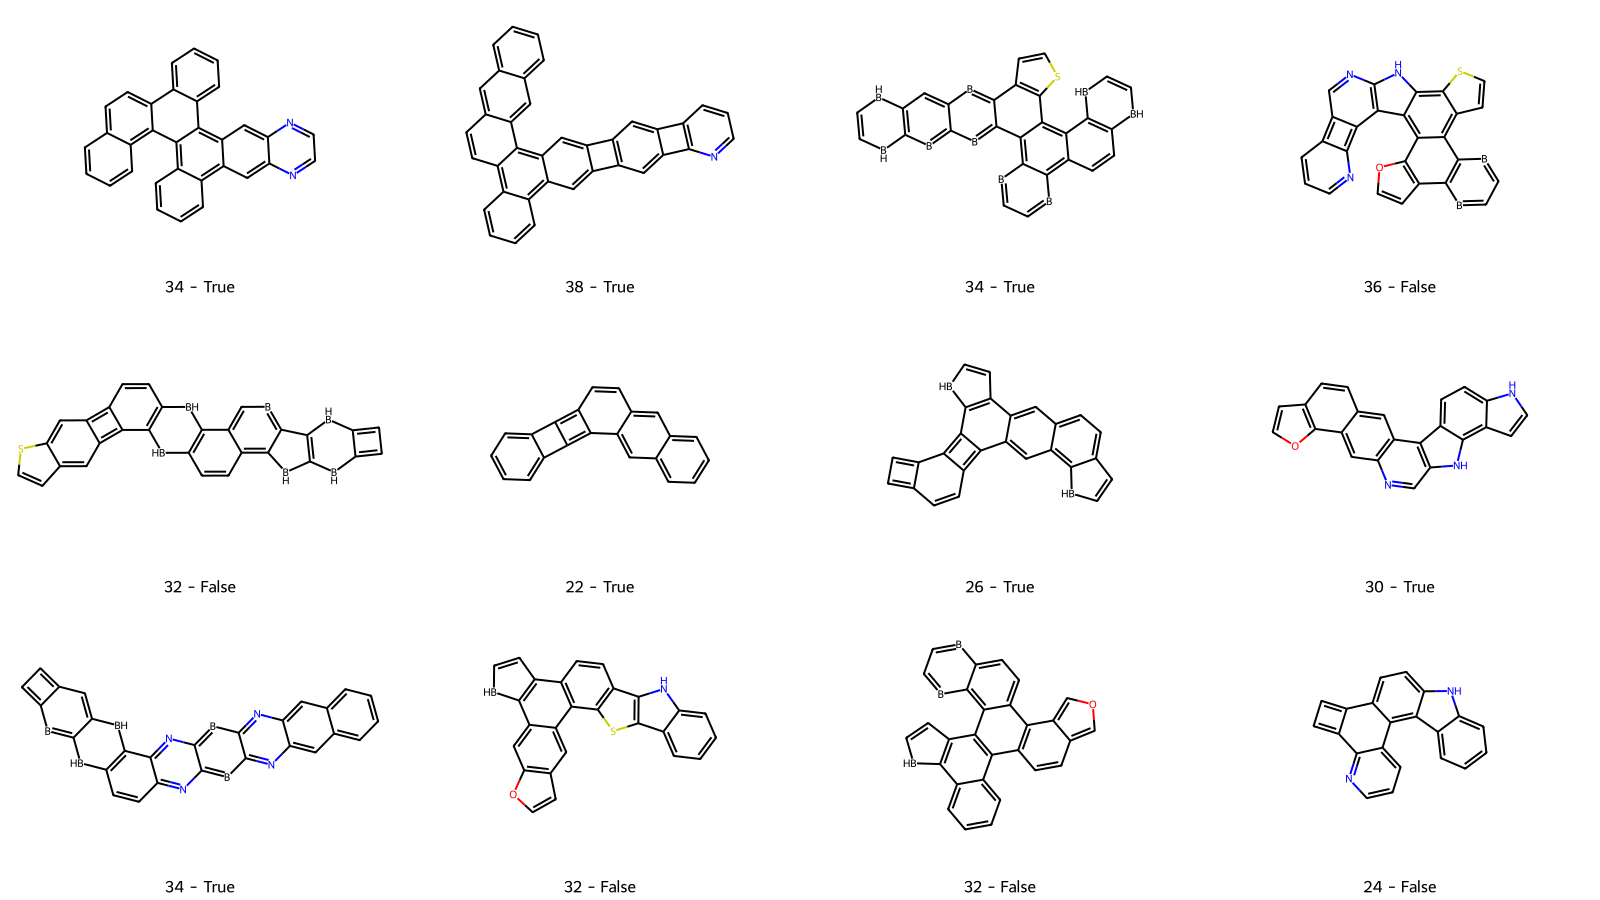

In [22]:
smis = df.iloc[:12]['smiles']
Draw.MolsToGridImage([Chem.MolFromSmiles(smi) for smi in smis], subImgSize=(400,300), molsPerRow=4,
                     legends=[f'{get_pi_electron_from_smiles(smi)} - {get_huckel_aromaticity_from_smiles(smi)}' for smi in smis])

# Plotting Properties Hued by Huckel Aromaticity

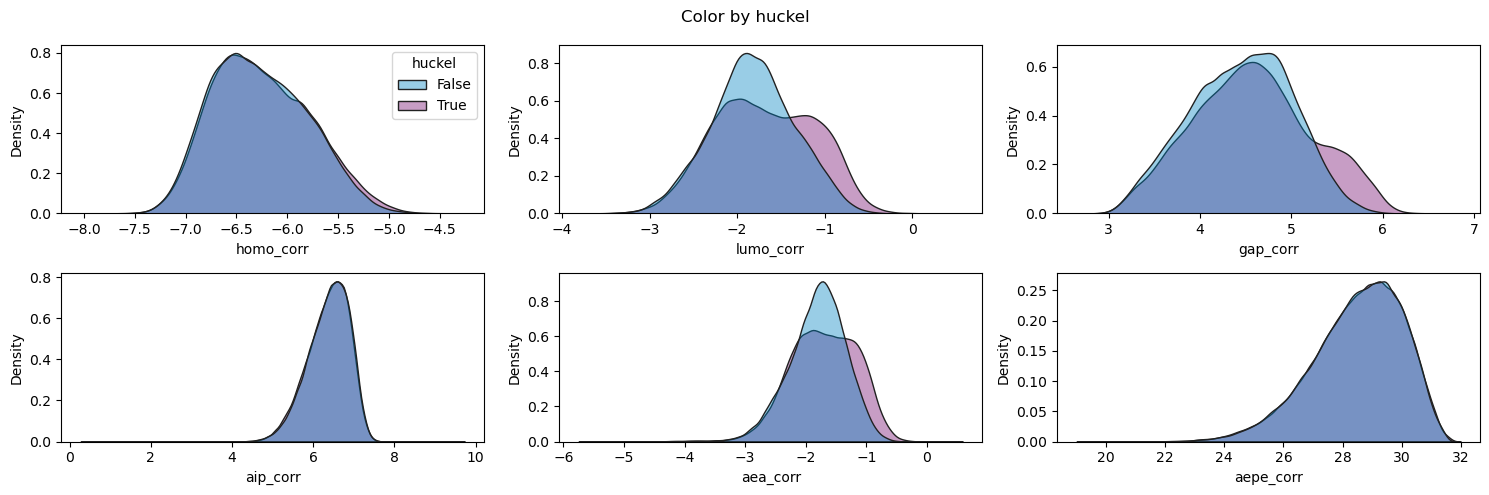

In [7]:
from colors import cmap

kde_kwargs = {
            # 'palette':cmap,
            'alpha':0.4,
            'edgecolor':'#212121',
            'common_norm':False,
}
props = ['homo_corr','lumo_corr','gap_corr','aip_corr','aea_corr','aepe_corr']

def plotkde_properties_hued_by(dataset, hue, remove_legend=False, **kwargs):
    fig, axs = plt.subplots(2, 3, figsize=(15, 5))
    axs = axs.flatten()
    for i, prop in enumerate(props):
        sns.kdeplot(data=dataset, x=prop, 
                    fill=True,
                    hue=hue,
                    warn_singular=False,
                    ax=axs[i],
                    **kwargs
                    )
        if remove_legend: axs[i].legend_.remove()
        remove_legend = True
    fig.suptitle(f"Color by {hue}")
    plt.tight_layout()
    return fig, axs

for hue in ['huckel']:
    fig = plotkde_properties_hued_by(df.query('rings == 9'), hue,
                    palette=['#0082C1','#730B6E'],
                    # common_norm=False,
                    **kde_kwargs
                    )